# Проект: классификация

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [281]:
df = pd.read_csv('bank_fin.zip', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [282]:
# Пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [283]:
df['job'].unique()
# Пропуски в таблие записаны как unknown

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [284]:
# Убираем знак $ из balance
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)
df['balance'].mean()

1529.1290293615875

### Задание 4

In [285]:
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean()

1526.9360329690019

### Задание 5

In [286]:
df = df.replace('unknown', np.nan)
df['job'] = df['job'].replace(np.nan, df['job'].mode()[0])
df['education'] = df['education'].replace(np.nan, df['education'].mode()[0])
df_5 = df[(df['education'] == df['education'].mode()[0]) & (df['job'] == df['job'].mode()[0])]
df_5['balance'].mean()

1598.8829787234042

### Задание 6

In [287]:
# Находим квантили
Q1 = np.percentile(df['balance'], 25)
Q3 = np.percentile(df['balance'], 75)

# Вычисление IQR
IQR = Q3 - Q1

# Определение нижней и верхней границ по методу Тьюки
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

df.shape 

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

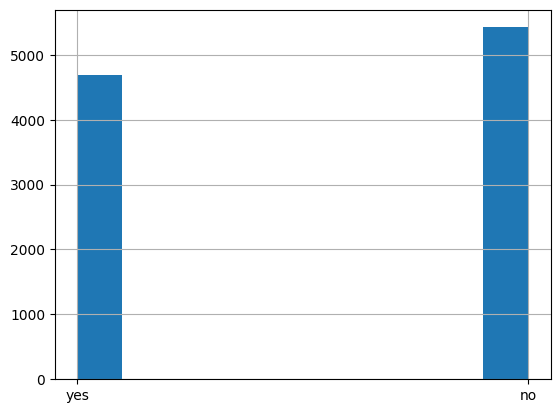

In [288]:
df.deposit.hist()
df.deposit.value_counts()

### Задания 2 и 3

In [289]:
df.age.max()
df.duration.min()

2

### Задания 4 и 5

In [290]:
df.job.unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

### Задание 6

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861


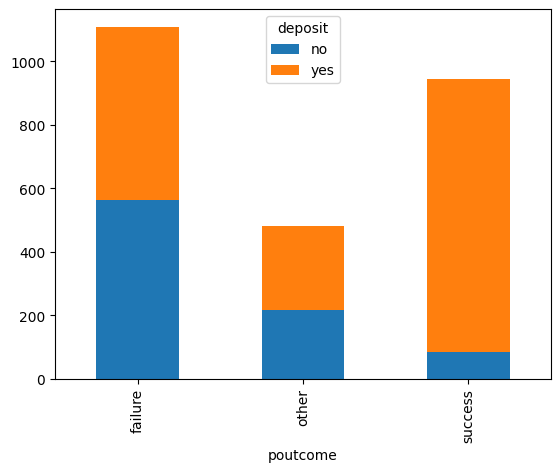

In [291]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')
types

### Задание 7

In [292]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
for i in np.unique(df.month):
    print(i, df[(df.month == i)&(df.deposit == 'no')].shape[0]/df[(df.month == i)].shape[0])

apr 0.3819277108433735
aug 0.5595667870036101
dec 0.0967741935483871
feb 0.45557122708039494
jan 0.6081504702194357
jul 0.5895627644569816
jun 0.5489130434782609
mar 0.10126582278481013
may 0.6786396637371036
nov 0.5846153846153846
oct 0.18507462686567164
sep 0.16546762589928057


### Задание 8

In [293]:
# создайте возрастные группы и определите, 
# в каких группах более склонны открывать депозит, 
# чем отказываться от предложения
def groups(data):
    if data < 30:
        return '<30'
    elif data < 40:
        return '30-40'
    elif data < 50:
        return '40-50'
    elif data < 60:
        return '50-60'
    else:
        return '60+'

df['group'] = df['age'].apply(groups)
import seaborn as sns
import matplotlib.pyplot as plt

# Подсчет количества значений в каждой категории "group"



for i in np.unique(df.group):
    print(i, df[(df.group == i)&(df.deposit == 'yes')].shape[0]/df[(df.group == i)].shape[0])


30-40 0.4332239333501641
40-50 0.39378673383711166
50-60 0.40507859733978235
60+ 0.7595712098009189
<30 0.5917525773195876


### Задания 9 и 10

age                                                        \
marital   divorced                    married                     single   
education  primary secondary tertiary primary secondary tertiary primary   
deposit                                                                    
no              91       370      163     641      1830      832     100   
yes             96       283      174     339      1289      784      82   

                              balance  ... poutcome previous            \
marital                      divorced  ...   single divorced             
education secondary tertiary  primary  ... tertiary  primary secondary   
deposit                                ...                               
no              866      531       91  ...      106       91       370   
yes             879      755       96  ...      300       96       283   

                                                                          
marital            married                     single                     
education tertiary primary secondary tertiary primary secondary tertiary  
deposit                                                                   
no             163     641      1830      832     100       866      531  
yes            174     339      1289      784      82       879      755  

[2 rows x 135 columns]

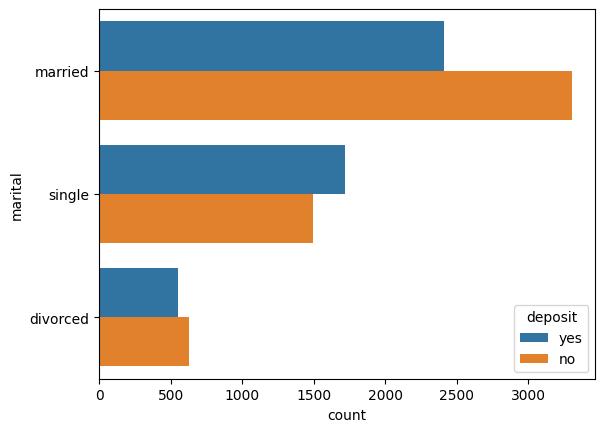

In [294]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

df.job.value_counts()

df_m = df.pivot_table(columns= ['marital', 'education'], index = 'deposit', aggfunc='count')
sns.countplot(y='marital', hue='deposit', data=df)
df_m

### Задание 11

In [295]:
# постройте сводную таблицу, 
# чтобы определить люди с каким образованием 
# и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

df_11 = df[df.deposit == 'yes']
df_11 = df_11.groupby(['marital', 'education'])

## Часть 3: преобразование данных

### Задание 1

In [296]:
lab_enc = LabelEncoder()

# Кодирование признака
df['education'] = lab_enc.fit_transform(df['education'])
df['education'].sum()

11995

### Задания 2 и 3

In [297]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df['deposit'].std()

df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan']= df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
print(df['default'].mean() + df['housing'].mean() + df['loan'].mean())
df['default'].mean()

0.6354280059376547


0.016427511133102424

### Задание 4

In [298]:
# создайте дамми-переменные
dummies = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome', 'default', 'housing', 'loan']])

# Объединение с исходным DataFrame
df = pd.concat([df, dummies], axis=1)
print(((df.columns)))

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit', 'group', 'default', 'housing',
       'loan', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success'],
      dtype='object')


### Задания 5 и 6

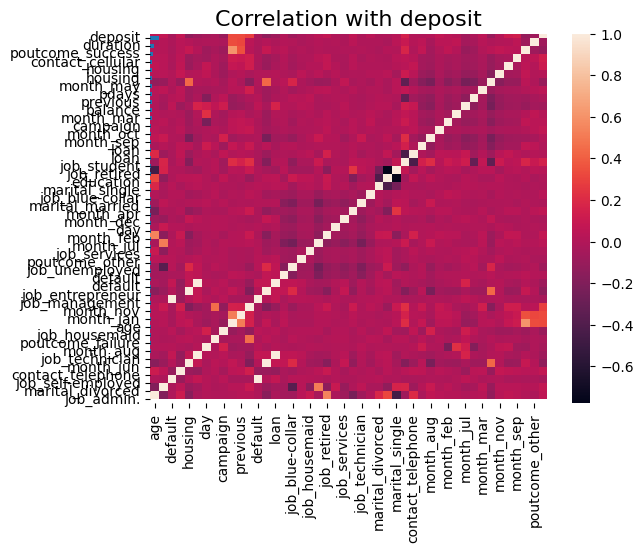

In [315]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.heatmap(df.corr())
corr_matrix = df.corr()

corr_matrix["deposit"].apply(lambda x: abs(x)).sort_values().plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

### Задания 7 и 8

In [300]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [301]:
# рассчитайте необходимые показатели

### Задание 9

In [302]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [303]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [304]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [305]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [306]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [307]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [308]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [309]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [310]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [311]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna